# Q-Learning in OpenAI's frozen lake
We are going to implement basic Q-Learning in OpenAI's gym "Frozen Lake v0" and look at some statistics to know how well we are performing

In [1]:
# Notebook imports
from tqdm import tnrange, tqdm_notebook

## Load environment

In [2]:
import gym
from gym import wrappers
# Create env
env = gym.make("FrozenLake-v0")
# Setup wrapper
outdir = 'tmp/qlearning-results'
env = wrappers.Monitor(env, directory=outdir, force=True)
# Set seed for replication 
env.seed(42)

[2017-10-09 22:33:12,436] Making new env: FrozenLake-v0
[2017-10-09 22:33:13,029] Clearing 40 monitor files from previous run (because force=True was provided)


[42]

## Setup Q table and support structures

In [3]:
import numpy as np
from collections import deque
# Create a table with dimensions: state-dimensions x action-dimension
Q = np.zeros((env.observation_space.n, env.action_space.n))
# Create a list of all the previous rewards for statistics
r_history = []
r_history_100 = deque(maxlen = 100)
mean_r_history = []
mean_r_history_100 = []

## Parameters tuning

In [4]:
GAMMA = 0.9
ALPHA = 0.8
EPSILON = 0.8
N_EPISODES = 10000

## Run the agent

In [5]:
import math
for episode in tqdm_notebook(range(N_EPISODES), desc='Episodes'):
    s = env.reset()
    done = False
    total_reward = 0
    while not done:
        # Choose action gredily with possible random action for exploring
        a = np.argmax(Q[s,:])
        p = np.random.random()
        _eps = 1.0 - (EPSILON / (1 + episode / 1000))
        if p >= _eps:
            a = env.action_space.sample()
        # Take action
        s1, r, done, _ = env.step(a)
        # Update Q
        Q[s,a] = Q[s,a] + ALPHA * (r + GAMMA * np.max(Q[s1,:]) - Q[s,a])
        # Update total reward
        total_reward += r
        # Update state and loop
        s = s1
    # Add total reward to history
    r_history.append(total_reward)
    r_history_100.append(total_reward)
    mean_r_history.append(np.mean(r_history))
    mean_r_history_100.append(np.mean(r_history_100))
env.close()

[2017-10-09 22:33:13,113] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.0.47400.video000000.json
[2017-10-09 22:33:13,117] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.0.47400.video000001.json
[2017-10-09 22:33:13,126] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.0.47400.video000008.json
[2017-10-09 22:33:13,135] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.0.47400.video000027.json
[2017-10-09 22:33:13,154] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.0.47400.video000064.json
[2017-10-09 22:33:13,183] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning

## Plot mean reward

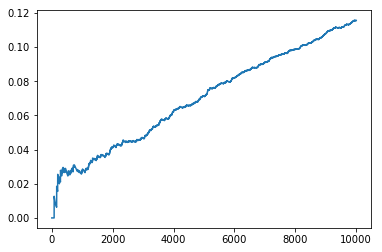

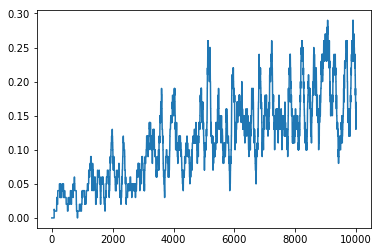

In [6]:
import matplotlib.pyplot as plt
plt.plot(mean_r_history)
plt.show()
plt.plot(mean_r_history_100)
plt.show()

## OpenAI gym's evaluation

In [7]:
from gym.scoreboard.scoring import score_from_local
print(score_from_local(outdir))

{'episode_t_value': None, 'timestep_t_value': None, 'mean': 0.28999999999999998, 'error': 0.050418005797948563, 'number_episodes': 10000, 'number_timesteps': 155355, 'seconds_to_solve': None, 'seconds_in_total': 8.4187016487121582}


## Q-Network
Now we will try to solve the same problem using Q-Network (approximation of Q function using a NN). Remember that we have 16 states (16 inputs) and 4 possible actions

In [8]:
import tensorflow as tf
# Rebuid environment
env = gym.make("FrozenLake-v0")
# Setup wrapper
outdir = 'tmp/qlearning-results'
env = wrappers.Monitor(env, directory=outdir, force=True)
# Set seed for replication 
env.seed(42)

[2017-10-09 22:33:24,429] Making new env: FrozenLake-v0
[2017-10-09 22:33:24,438] Clearing 40 monitor files from previous run (because force=True was provided)


[42]

We will build a simple TF network, with no hidden layer

In [9]:
# Create inputs, weights, outputs and prediction (max)
inputs = tf.placeholder(shape=[1,16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],minval=0,maxval=0.01))
output = tf.matmul(inputs, W)
predicted = tf.argmax(output, axis=1)
# Setup loss function
target_Q = tf.placeholder(shape=[1,4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(target_Q - output))
trainer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
updater = trainer.minimize(loss)
# Histories
r_history = []
r_history_100 = deque(maxlen = 100)
mean_r_history = []
mean_r_history_100 = []

Now run the network implementing the QN

In [10]:
# Initialize network
init = tf.global_variables_initializer()
# Start network
with tf.Session() as sess:
    sess.run(init)
    # Run episodes
    for episode in tqdm_notebook(range(N_EPISODES), desc='Episodes'):
        s = env.reset()
        done = False
        total_reward = 0
        while not done:
            # Estimate Q in current state. Current state is 1, other are 0s. A is the argmax, allQ is the output
            a, allQ = sess.run([predicted,output],feed_dict={inputs:np.identity(16)[s:s+1]})
            # Choose action gredily with possible random action for exploring
            p = np.random.random()
            _eps = 1.0 - (EPSILON / (1 + episode / 1000))
            if p >= _eps:
                a = env.action_space.sample()
            else:
                a = a[0]
            # Take action
            s1, r, done, _ = env.step(a)
            # Update Q. First get max of Q(s1), than apply Bellman
            Q1 = sess.run(output,feed_dict={inputs:np.identity(16)[s1:s1+1]})
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a] = r + GAMMA * maxQ1
            # Train network
            _,W1 = sess.run([updater,W],feed_dict={inputs:np.identity(16)[s:s+1],target_Q:targetQ})
            # Update total reward
            total_reward += r
            # Update state and loop
            s = s1
        # Add total reward to history
        r_history.append(total_reward)
        r_history_100.append(total_reward)
        mean_r_history.append(np.mean(r_history))
        mean_r_history_100.append(np.mean(r_history_100))
env.close()

[2017-10-09 22:33:24,623] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.1.47400.video000000.json
[2017-10-09 22:33:24,662] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.1.47400.video000001.json
[2017-10-09 22:33:24,767] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.1.47400.video000008.json
[2017-10-09 22:33:24,920] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.1.47400.video000027.json
[2017-10-09 22:33:25,219] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning-results/openaigym.video.1.47400.video000064.json
[2017-10-09 22:33:25,814] Starting new video recorder writing to /Users/nicom/Documents/Projects/openai/letitgo/tmp/qlearning

## Plot QN results

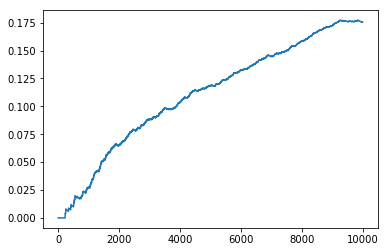

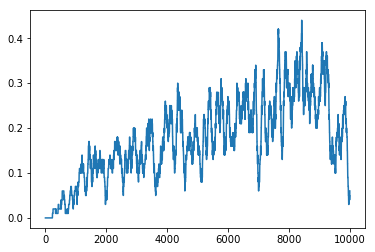

In [11]:
import matplotlib.pyplot as plt
plt.plot(mean_r_history)
plt.show()
plt.plot(mean_r_history_100)
plt.show()

## OpenAI scoring

In [12]:
from gym.scoreboard.scoring import score_from_local
print(score_from_local(outdir))

{'episode_t_value': None, 'timestep_t_value': None, 'mean': 0.44, 'error': 0.055154105093292702, 'number_episodes': 10000, 'number_timesteps': 171423, 'seconds_to_solve': None, 'seconds_in_total': 192.51412892341614}
